$y=ax+b+\epsilon$ 형태의 분포로 데이터를 모델링 할겁니다. $\epsilon$은 글로벌 파라미터이자 $x$에 의존하는 분포의 noise입니다.주된 목표는 $a$와 $b$를 좋게 추정하는 것입니다.<br> 

모델을 스튜던트 t-분포(shape과 scale 둘 다 $x$에 의존합니다.)를 이용해서 $\epsilon=y-ax+b$를 시도할겁니다. (mode(최빈값)는 zero로 가정합니다) 파라미터를 찾기 위해서, 우린 모델링 분포와 실험 데이터간의 크로스 엔트로피를 최소화하려 합니다; 이 최소화는 Gradient descent로 할 수 있습니다. (텐서플로우 라이브러리를 써서요! www.tensorflow.org)<br>

오버피팅 방지를 위해 L2 regularization을 쓸겁니다. 선택한 regularization의 힘은 cross-validation error의 베이지안 최적화에서 나옵니다. 마지막에는 데이터를 섞고 나눠서, 60%의 데이터는 트레이닝, 20%의 데이터는 validation, 20%의 데이터는 testing용으로 3개의 그룹을 만듭니다.<br><br>

In [1]:
import tensorflow as tf
import tensorflow.contrib.distributions as dist
import numpy as np
import pandas as pd
from numpy import pi
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import FloatProgress
from IPython.display import display

testing_proportion = 0.2
validation_proportion = 0.2

hyper_param_dim=6
l2_reg_min,l2_reg_max = -50,0
sqrt_2 = np.sqrt(2.).astype(np.float32)
sqrt_5 = np.sqrt(5.).astype(np.float32)
# The folowing are global settings used for the bayesian optimization of the hyper-parameters.
initial_GP_test_points = 5 # these are randomly chosen points with which to initialize the bayesian optimization
total_GP_test_points = 20 # total number of points used in bayesian optimization
max_feelers = 10 # number of points used in batch-gradient-descent optimization.

import하고 데이터를 plot해서 보죠

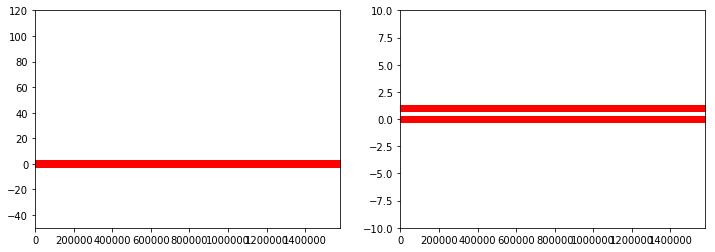

In [2]:
# First, we import and shuffle the data.
# data = pd.read_csv("data.csv").as_matrix()
data = pd.read_csv('Sentiment_Analysis.csv').as_matrix()

x_min,x_max = np.min(data[:,0])-1,np.max(data[:,0])+1
y_min,y_max = np.min(data[:,1])-1,np.max(data[:,1])+1

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_ylim(-50,120)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(-10,10)
ax1.plot(data[:,0],data[:,1],'ro')
ax2.plot(data[:,0],data[:,1],'ro')
plt.show()

이제 테스트 데이터를 섞고 나눕시다.<br>

In [3]:
# First, we shuffle the data.
data = np.random.permutation(data)
data_len,_ = data.shape
# Next we divide the data into (training and validation) vs testing sets
test_data_len = int(np.floor(data_len*testing_proportion))
valid_data_len = int(np.floor(data_len*validation_proportion))
# the testing set gets a data slice of size test_data_len
test_data = data[:test_data_len,:] 
# the train/validation set gets the rest
train_and_valid_data=data[test_data_len:,:]

섞은 다음 training과 validation 세트로 나눌 수 있게 도와주는 함수를 적어봅시다. 나중에 cross validation을 통한 hyperparameter들을 선택에 도움이 될겁니다.<br>

In [4]:
def train_and_valid_set_split():
    shuffled_train_and_valid_data = np.random.permutation(train_and_valid_data)
    # the validation set gets the next data slice of size valid_data_len
    valid_data = shuffled_train_and_valid_data[:valid_data_len,:]
    # the training data is whatever's left.
    train_data = shuffled_train_and_valid_data[valid_data_len:,:]
    return train_data,valid_data

모델의 input 데이터와 모델의 target 데이터, regularization strength (regularization term의 constant lambda. 0이면 쓰지않는 것이고, 1이면 이 부분을 강력하게 쓰겠다는 뜻) hyperparameter를 넣을 placeholder를 만들어봅시다.<br>

In [5]:
# Create a placeholder for the input data
x = tf.placeholder(tf.float32, shape = [None]) # here shape=[None] refers to a variable length vector
# Create a placeholder for the target data
y_ = tf.placeholder(tf.float32, shape = [None]) # here shape=[None] refers to a variable length vector
# Create a placeholder for the hyper-paremeters
l2_reg_strength = tf.placeholder(tf.float32,shape = [hyper_param_dim]) # here shape=2 refers to vector of length 2.

$\epsilon$의 mode는 $y=ax+b$여야 합니다. $a$값과 $b$값을 배우길 바라죠, 그러니 이 녀석들을 위한 변수 정의(0으로 initialize한)를 해봅시다.<br>

In [6]:
with tf.variable_scope('model'):
    a = tf.Variable(initial_value = tf.constant(0.),name = "slope_of_mode")
    b = tf.Variable(initial_value = tf.constant(0.),name = "x_intercept_of_mode")
    y = a*x+b

스튜던트 t-분포를 통한 노이즈를 모델링해 봅시다<br>

$$\frac{\Gamma(\frac{\nu+1}{2})}{\sigma \sqrt{\nu \pi}\Gamma(\frac{\nu}{2})}\left[\frac{\nu+(\frac{y-\mu}{\sigma})^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$<br>

파라미터들은 : mode $\mu$, scale $\sigma>0$, shape $\nu>0$

shape이랑 scale을 $x$와 다르게 하길 원합니다. 데이터의 plot을 보면, data points들은 $x=0$ 근처에 집중되어 있습니다. 그리고 $x$가 증가하듯 퍼져있습니다; 이 현상을 포착하기 위해, 분포의 크기를 위한 간단한 functional 형태를 선택할것입니다 ($x$의 함수처럼):<br><br>
$$\sigma=w_{bias}((\frac{w_{slope}}{w_{bias}}x-w_{arg-min})^2+1)^{w_{pow}}$$<br>
간결함을 위해, $x=w_{arg-min}$에서 $\sigma(x)$를 대칭(symmetric)이라고 가정합니다. $w_{pow}=1/2$일때, $w_{slope}$는 $\sigma(x)$ 크기 변화의 점진적 비율입니다. 그리고 $\sigma(x)$의 functional 형태는 베이지안 진단 선형 가우시안 회귀법(사후확률을 적분한, t-분포 안의 결과들); $\sigma(x)$를 위한 functional 형태는 바로 모델에 넣는 $b$ 값에서 약간의 불확실성을 포함하게 합니다. 약간 다르게 하면, $w_{pow}$의 정확한 값을 배울 수 있게 합니다.<br>

$\nu$ shape도 비슷한 functional 형태로 줍니다.

In [7]:
with tf.variable_scope('model'):
    log_bias_scale = tf.Variable(tf.constant(0.),name="scale_log_bias")
    arg_min_scale = tf.Variable(tf.constant(0,tf.float32),name="scale_arg_min")
    slope_scale = tf.Variable(tf.constant(1.),name="scale_log_slope")
    pow_scale = tf.Variable(tf.constant(.5,name='power_for_scale'))
    scale = tf.pow(tf.square(slope_scale*(x-arg_min_scale))/tf.exp(log_bias_scale)+1.,
                   pow_scale, name="scale")*tf.exp(log_bias_scale)

    log_bias_shape = tf.Variable(tf.constant(0.),name="shape_log_bias")
    arg_min_shape = tf.Variable(tf.constant(0,tf.float32),name="shape_arg_min")
    slope_shape = tf.Variable(tf.constant(1.),name="shape_log_slope")
    pow_shape = tf.Variable(tf.constant(-.5,name='power_for_shape'))
    shape = tf.pow(tf.square(slope_shape*(x-arg_min_shape))/tf.exp(log_bias_shape)+1.,
                   pow_shape,name="shape")*tf.exp(log_bias_shape)

이 변수들을 스튜던트 t-분포에 넣어보자

In [8]:
model_distribution = dist.StudentT(df = shape, loc = y, scale = scale)

실증적 데이터와 모델링된 분포사이의 크로스 엔트로피를 줄여봅시다. $H(p,q)=-\int p(y\mid x)\log(q(y\mid x,\mathrm{parameters}))$를 줄이는데에 관심이 많죠. ($p$는 실제 분포를 나타내고, $q(x|\mathrm{parameters})$는 맞추려는 모델을 나타냅니다); 파라미터의 공간을 너머 최소화 됩니다. $H(p,q)$ 추정은:<br><br>
$$-\sum_{i=1}^N\frac{1}{N}\log(q(y_i\mid x_i,\mathrm{parameters}))$$<br>
L2-regularization을 포함한 (Adam) gradient descent 를 써서 최소화를 달성합니다: 우리의 prior beliefs는 하이퍼파라미터의 scale과 shape 각각을 위한 정규 분포로 encode합니다. <br><br>

이전 방법은 $\nu$ shape이 상수이거나 점진적으로 $1/x$로 떨어지는 경향(최대값이 0 근처)이 있는 동안, $\sigma$는 상수이거나 점진적으로 선형 증가하는 경향(최소값이 0 근처)이 있다.<br><br>
이런 prior beliefs (정규 분포의 variance로 사전 확률을 모델링)속의 우리 자신감은 검증 셋 측정을 cross-entropy error의 베이지안 최적화를 사용해서 배우게 한다는 것이다. 

In [9]:
# We compute a vector of log-likelihoods
log_likelihoods = model_distribution.log_prob(y_)
# the cross_entropy is the mean of the log_likelihoods
cross_entropy = -tf.reduce_mean(log_likelihoods)
# we optimize via (Adam) gradient descent
with tf.variable_scope('training_model'):
    model_lr = tf.placeholder(tf.float32)
    optimizer = tf.train.AdamOptimizer(model_lr)
    # the gradient descent objective incorporates our priors via L2 regularization to compute the MAP
    train = optimizer.minimize(cross_entropy
                           +tf.reduce_sum(tf.multiply(l2_reg_strength,tf.stack(
                [tf.nn.l2_loss(slope_scale),tf.nn.l2_loss(pow_scale-.5),
                 tf.nn.l2_loss(slope_shape),tf.nn.l2_loss(pow_shape+.5),
                 tf.nn.l2_loss(arg_min_scale),tf.nn.l2_loss(arg_min_shape)]))))

우리의 파라미터들을 위해 MAP 추정을 계산할 코드를 써보자. 데이터를 training과 cross validation 셋으로 나누는 걸로 시작해서, training 셋에 gradient descent를 적용해서 MAP 추정을 얻는다, validation 셋을 통해 cross-entropy 추정을 돌려준다.<br>

Note : validation 셋과 training에 non-testing 데이터를 랜덤하게 나눠서 넣습니다; 우리는 validation 셋을 측정하는 cross-entropy error의 평균과 분산 추정을 위해 implicitly bootstrapping함.<br>

In [10]:
def train_model(l2_reg_strength_val,num_steps=1000,verbose=False,learning_rate=0.05):
    # First we initialize the variables in the model and the training optimizer:
#     model_variables = tf.get_collection(tf.GraphKeys.VARIABLES, scope='model')
    model_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model')
    tf.variables_initializer(model_variables).run()
    training_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='training_model')
    tf.variables_initializer(training_variables).run()
    # Next we split the training/validation data:
    train_data,valid_data = train_and_valid_set_split()
    for step in range(num_steps+1):
        training_loss,_ = sess.run([cross_entropy,train],
                                   {x:train_data[:,0],
                                    y_:train_data[:,1],
                                    l2_reg_strength:l2_reg_strength_val,
                                   model_lr:learning_rate})
        if verbose and step % 100 == 0:
            print("step: %d, loss: %.3f, a: %.4f, b: %.4f, min scale: %.4f, scale rate of change: %.4f, \n \
                     min shape: %.4f shape rate of change: %.2f"
                  %(step,training_loss, a.eval(), b.eval(),
                    tf.exp(log_bias_scale).eval(),tf.abs(slope_scale).eval(),
                    tf.exp(log_bias_shape).eval(),tf.abs(slope_shape).eval()))
        
    return cross_entropy.eval({x:valid_data[:,0],y_:valid_data[:,1]})

resulting model plot을 위한 도우미 함수를 또 소개해 봅니다. $y=ax+b$ 선은 파란색이고, 확률 밀도(probability density)는 녹색, standard deviation($\nu>2$일때 정의되는)은 보라색입니다.

In [11]:
def plot_model(ylim=None):
    x_step_size=(x_max-x_min)/20.
    y_step_size=(y_max-y_min)/20.
    x_grid = np.arange(x_min,x_max,x_step_size)
    y_grid = np.arange(y_min,y_max,y_step_size)
    fig, ax = plt.subplots()
    
    # Plot the predicted probability density
    X,Y = np.meshgrid(x_grid, y_grid)
    Z = np.exp(log_likelihoods.eval({x:X.reshape(-1),y_:Y.reshape(-1)})).reshape(len(x_grid),len(y_grid))
    ax.contourf(X,Y,Z,cmap='YlGn')
    ax.autoscale(False)
    
    # plot the predicted mode
    ax.plot(x_grid,a.eval()*x_grid+b.eval(),linewidth=2)
    
    # plot the standard deviation
    # first, restrict to where it's defined
    x_std_dev_defined = x_grid[shape.eval({x:x_grid})>2]
    # then compute the standard deviation
    std_dev = (scale*tf.sqrt((shape/(shape-2.)))).eval({x:x_std_dev_defined})
    # now plot it
    ax.plot(x_std_dev_defined,a.eval()*x_std_dev_defined+b.eval()+std_dev,'purple')
    ax.plot(x_std_dev_defined,a.eval()*x_std_dev_defined+b.eval()-std_dev,'purple')
    
    #plot the data
    ax.plot(data[:,0],data[:,1],'ro')
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.show()

오케이, 텐서플로 세션(test하고 training하는 알고리즘)을 시작하죠:

step: 0, loss: 20.601, a: 0.0500, b: 0.0461, min scale: 0.9512, scale rate of change: 0.9500, 
                      min shape: 1.0513 shape rate of change: 0.95
step: 100, loss: 11.967, a: 0.0601, b: 0.0212, min scale: 0.9835, scale rate of change: 0.6953, 
                      min shape: 2.0661 shape rate of change: 0.18
step: 200, loss: 19.871, a: -0.2362, b: -0.1928, min scale: 1.4287, scale rate of change: 0.8315, 
                      min shape: 1.6959 shape rate of change: 0.03
step: 300, loss: 13.456, a: -0.2889, b: -0.0756, min scale: 1.4435, scale rate of change: 0.5106, 
                      min shape: 2.8570 shape rate of change: 0.17
step: 400, loss: 13.021, a: -0.1856, b: 0.3255, min scale: 1.4074, scale rate of change: 0.4659, 
                      min shape: 2.8967 shape rate of change: 0.20
step: 500, loss: 15.099, a: 0.1585, b: 0.9392, min scale: 1.6003, scale rate of change: 0.7286, 
                      min shape: 2.8866 shape rate of change: 0.19
step: 600, lo

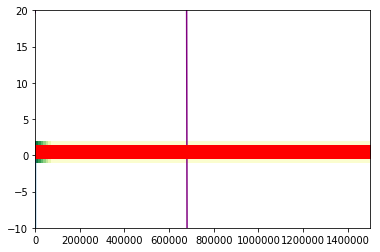

In [12]:
sess = tf.InteractiveSession()
print("-"*30+"\n validation-cross-entropy estimate: %f"
      %train_model(l2_reg_strength_val = [0.0,0.0,0.0,0.0,0.0,0.0],num_steps=1000,verbose=True))
plot_model(ylim=[-10,20])

---------------

gradient descent는 validation-cross-entropy 추정의 합당한 추정을 위한 500번 이후, 충분히 수렴되는 경향이 있다. 이제 우리는 validation-cross-entropy 추정을 최소화해서 하이퍼파라미터들 추정을 해야한다. 이를 위한 몇가지 방법이 있다.<br>
- 하이퍼 파라미터들을 grid search 한다.<br>
- 하이퍼 파라미터들을 random search 한다.<br>
- validation-cross-entropy (Nelder-Mead를 통한다 할 수 있는)를 수치적으로 최적화한다.<br>
- Bayesian 최적화를 한다.<br>

우리는 Bayesian 최적화 과정의 윤곽이 나타난 https://arxiv.org/pdf/1206.2944.pdf 의 간단한 버전을 사용한다.<br>

더 세부적으로, (하이퍼 파라미터들의) 가우시안 프로세스처럼 validation-cross-entropy를 모델링할거다. 가우시안 프로세스를 모델하기 위해, 평균을 계산하는 도우미 함수를 소개한다 (단순화를 위해 분산(variance)은 무시한다): kernel $k(x,x')$, 샘플된 값 $\{y_i\}$와 샘플된 포인트 $\{x_i\}$를 주면, 평균은<br><br>
$$\mu(x):=k(x,x_i)k_{ij}^{-1}y_j,$$<br>

$k_{ij}=k(x_i,x_j)$ entries를 가진 매트릭스 $k_{ij}$에서.

In [13]:
# new_points is assumed to be a list of points
def GP_mean(kernel,GP_sampled_x,GP_sampled_y,new_points):
    # First compute the sample mean:
    sampled_mean_y=tf.reduce_mean(GP_sampled_y,0)
    
    inv_cov_matrix = tf.matrix_inverse(kernel(GP_sampled_x,GP_sampled_x))
    # reshape the the sample values into matrices:
    GP_sampled_y_reshaped = tf.reshape(GP_sampled_y,[-1,1])
    # return the expected mean
    return sampled_mean_y + tf.matmul(kernel(new_points,GP_sampled_x),
                             tf.matmul(inv_cov_matrix,GP_sampled_y_reshaped-sampled_mean_y))

공분산을 계산하기 위한 두번째 도우미 함수를 소개한다. 세부적으로 공분산 매트릭스(covariance matrix)는:<br><br>
$$\Sigma(x):=k(x,x)-k(x,x_i)k_{ij}^{-1}k(x_j,x)$$


In [14]:
def GP_cov(kernel,GP_sampled_x,new_points):
    inv_cov_matrix = tf.matrix_inverse(kernel(GP_sampled_x,GP_sampled_x))
    k=kernel(GP_sampled_x,new_points)
    return kernel(new_points,new_points)-tf.matmul(tf.transpose(k),tf.matmul(inv_cov_matrix,k))

가우시안 프로세스로 validation-cross-entropy error를 모델링한다. 만약 $\epsilon_{min}$가 validation-cross-entropy error의 현재 최소 샘플된 값이고, 만약 새로운 포인트 $x_{new}$에서 샘플하면, $$\epsilon_{min}-\mu(x_{new}).$$<br>로 validation-cross-entropy 샘플된 값은 줄어들거라 예상할 수 있다.<br><br>
**기대 개선(expected improvement)**  함수는 아래처럼 정의된다.<br><br>
$$a_{EI}(x_{new})=\mathbb{E}[\operatorname{max}(\epsilon_{min}-\mu(x_{new}),0)],$$<br>

이를 최대화하는 포인트 $x_{new}$에서의 샘플을 원한다. 이어지는 코드는 cross-entropy error (validation 셋을 측정한)를 위한 현재의 가우시안 프로세스 모델이 주어졌을 때, 기대 개선을 계산하는 함수 ```GP_expected_improv```를 위한 것이다.<br>

In [15]:
# new_points is a (num_points,amb_dim) shape matrix of prospective points at which to
# measure the cross-entropy (on the validation set)

def GP_expected_improv(kernel,GP_sampled_x,GP_sampled_y,new_points):
    # compute the mean of the gaussian process at new_points
    mu = tf.reshape(GP_mean(kernel,GP_sampled_x,GP_sampled_y,new_points),[-1])
    # compute the standard deviation across those new_points
    sigma = tf.diag_part(GP_cov(kernel,GP_sampled_x,new_points))
    # check that the standard deviation is positive (and fill in a dummy value of 1 otherwise)
    non_zero_variance = tf.greater(sigma, 0., name="variance_Control_Op")
    sigma_safe = tf.where(non_zero_variance,sigma,tf.tile(tf.constant([1.]),tf.shape(sigma)))
    # model our expected cross-entropy at those new points using the gaussian process
    normal_distribution = dist.Normal(loc = mu, scale = sigma_safe)
    # compare our model with the current minimum
    min_sampled_y = tf.reshape(tf.reduce_min(GP_sampled_y),[-1])
    # compute the expected value of max(min_sampled_y - mu)
    result = (min_sampled_y-mu)*normal_distribution.cdf(min_sampled_y)+sigma*normal_distribution.prob(min_sampled_y)
    return tf.where(non_zero_variance,result,tf.tile(tf.constant([0.]),tf.shape(non_zero_variance)))

# the ``probability of improvement'' is computed with the following code, but we found it to be less effective.

def GP_log_prob_of_improv(kernel,GP_sampled_x,GP_sampled_y,new_points):
    mu = tf.reshape(GP_mean(kernel,GP_sampled_x,GP_sampled_y,new_points),[-1])
    sigma = tf.diag_part(GP_cov(kernel,GP_sampled_x,new_points))
    non_zero_variance = tf.greater(sigma, 0., name="variance_Control_Op")
    sigma_safe = tf.where(non_zero_variance,sigma,tf.tile(tf.constant([1.]),tf.shape(sigma)))
    normal_distribution = dist.Normal(loc = mu, scale = sigma_safe)
    min_sampled_y = tf.reshape(tf.reduce_min(GP_sampled_y),[-1])
    return tf.where(non_zero_variance,
                    normal_distribution.log_cdf(min_sampled_y),
                    tf.tile(tf.constant([0.]),tf.shape(non_zero_variance)))
    

 https://arxiv.org/pdf/1206.2944.pdf 에서 소개된, 가우시안 프로세스를 위한 5/2 maternal kernel를 사용한다:<br><br>
$$k(x,y)=\theta_0\bigg(1+\sqrt{5 r^2(x,y)}+\frac{5}{3}r^2(x,y)\bigg)e^{-\sqrt{5 r^2(x,y)}}+\sigma_0^2\delta(x,y),$$<br>
$r(x,y)$는 $x$와 $y$ 사이의 거리이다. 거리 함수 $r(x,y)$ 또한 길이 크기의 파라미터들을 갖고 있는 동안, kernel은 $\sigma_0$ (샘플 noise), $\theta_0$ (kernel 크기) 파라미터들을 갖고 있다. 적용은 아래와 같다<br>

In [16]:
# Both points_1 and points_2 are assumed to be numpy arrays of shape (num_points_1,amb_dim) and (num_points_2,amb_dim)
# these functions return matrices of shape (num_points_1,num_points_2) whose entries are the values of the matern kernel
# on the corresponding pair of points.
# length_scale is assumed to be of shape (amb_dim).


def matern_kernel(points_1,points_2,log_length_scale,log_sample_noise = None,log_kernel_scale=0.):
    # First we compute the distances:
    distances_squared = distances_squared_matrix(points_1,points_2,log_length_scale)
    noise_shift = 0
    if points_1 == points_2:
        # make sure the diagonal consists of zeros to compute the square root safely
        distances_squared = zeros_diag(distances_squared)
        if log_sample_noise != None:
            # add intrisic sampling noise; it is essential that we include this since we are bootstrapping.
            noise_shift = tf.diag(tf.tile([tf.exp(log_sample_noise)],[tf.shape(points_1)[0]]))
    distances = tf.sqrt(distances_squared)
    
    return tf.exp(log_kernel_scale)*(1+sqrt_5*distances + 5*distances_squared/3.) \
            *tf.exp(-sqrt_5*distances) + noise_shift

def gaussian_kernel(points_1,points_2,log_length_scale,log_sample_noise = None,log_kernel_scale=0.):
    # First we compute the distances:
    distances_squared = distances_squared_matrix(points_1,points_2,log_length_scale)
    if log_sample_noise != None and points_1 == points_2:
        # make sure the diagonal consists of zeros to compute the square root safely
        distances_squared = zeros_diag(distances_squared)
        # add intrisic sampling noise.
        noise_shift = tf.diag(tf.tile([tf.exp(log_sample_noise)],[tf.shape(points_1)[0]]))
    else: noise_shift=0
    return tf.exp(log_kernel_scale)*tf.exp(-distances_squared) + noise_shift

# Here is the a helper distance function:
def distances_squared_matrix(points_1,points_2,log_length_scale):
    # First we rescale the points
    inv_scale=tf.exp(-tf.reshape((log_length_scale),[1,-1]))
    res_points_1=tf.multiply(points_1,inv_scale)
    res_points_2=tf.multiply(points_2,inv_scale)
    # Next we compute the distances,
    # we are using the formula (x-y)(x-y) = x^2-2xy+y^2
    Radial_dist_1=tf.reduce_sum(tf.multiply(res_points_1,res_points_1),1,keep_dims=True)
    Radial_dist_2=tf.reduce_sum(tf.multiply(res_points_2,res_points_2),1,keep_dims=True)
    distances_squared = Radial_dist_1-2*tf.matmul(res_points_1,tf.transpose(res_points_2))+tf.transpose(Radial_dist_2)
    return distances_squared

# We need a numerically stable means to compute the log-determinant of a matrix when fitting the Gaussian process.
def log_determinant_for_PD_matrices(tensor):
    # first compute the cholesky decomposition M=R*R^T
    cholesy_root = tf.cholesky(tensor)
    # now det(M)=det(R)^2=(Prod diag_entries(R))^2
    # so log(det(M))=2*sum(log(diag_entries(R)))
    return 2*tf.reduce_sum(tf.log(tf.diag_part(cholesy_root)))

# we need the following to guarantee numerical stability...
def zeros_diag(matrix):
    # create a matrix with True along diagonal and False elsewhere (to be used as a mask)
    mask = tf.cast(tf.diag(tf.tile(tf.constant([1]),[tf.shape(matrix)[0]])),tf.bool)
    # create a zero matrix:
    zeros = tf.diag(tf.tile(tf.constant([0.]),[tf.shape(matrix)[0]]))
    
    return tf.where(mask,zeros,matrix)

이제 kernel 파라미터와 kernel 연결을 위한 텐서플로 변수들을 소개한다.

In [17]:
with tf.variable_scope('GP'):
    # Parameters for the Gaussian process
    GP_log_length_scale = tf.tile(tf.Variable(tf.constant([1.])),[hyper_param_dim])
    GP_log_sample_noise = tf.Variable(tf.constant(0.))
    GP_log_kernel_scale = tf.Variable(tf.constant(0.))
GP_kernel = lambda l2x,l2y:matern_kernel(l2x,l2y,GP_log_length_scale,GP_log_sample_noise,GP_log_kernel_scale)

$\{x_i\}$ 포인트에서 샘플 값 $\{y_i\}$의 array들의 가우시안 프로세스를 fit하는 코드를 적어보자. 첫번째로, 샘플 포인트들과 값들을 저장하는 placeholder들을 소개한다. 그리고 그들을 연결해서 새로운 점에서 우리의 함수는 평균과 공분산을 계산 한다.<br>

In [18]:
with tf.variable_scope('GP'):
    # Place holders for the sampled points and values.
    GP_sampled_x = tf.placeholder(tf.float32,shape = [None,hyper_param_dim])
    GP_sampled_y = tf.placeholder(tf.float32,shape = [None])
    # Placeholder for a new point at which to evaluate the gaussian process model.
    GP_new_x = tf.placeholder(tf.float32,shape = [None,hyper_param_dim])
    
GP_mean_func = GP_mean(GP_kernel,GP_sampled_x,GP_sampled_y,GP_new_x)
GP_cov_func = GP_cov(GP_kernel,GP_sampled_x,GP_new_x)
#GP_prob_of_improv_func = tf.exp(GP_log_prob_of_improv(GP_kernel,GP_sampled_x,GP_sampled_y,GP_new_x))

파라미터들을 위한 maximum likelihood estimate를 사용한 포인트 $\{x_i\}$에서 샘플된 값 $\{y_i\}$의 array에 가우시안 프로세스를 fit한다. 예시로<br><br> $$-\log N(\{y_i-\bar y\},0, k_{ij})=(y_i-\bar y)k_{ij}^{-1}(y_j-\bar y)+\log\operatorname{det}(k_{ij})+\mathrm{Const.}$$<br>를 최대화한다. $\bar y$는 샘플된 값들의 평균이고, 공분산 행렬(covariance matrix) $k_{ij}$는 $k_{ij}=k(x_i,x_j)$ entries를 갖고 있다. 

In [19]:
# GP_cov_matrix is the matrix k_{ij}
GP_cov_matrix = GP_kernel(GP_sampled_x,GP_sampled_x)
# GP_cov_matrix_inv is it's inverse
GP_cov_matrix_inv = tf.matrix_inverse(GP_cov_matrix)

# GP_mean_zero_sampled_y is the vector {y_i-\bar y}, with mean zero.
GP_mean_zero_sampled_y= tf.reshape((GP_sampled_y-tf.reduce_mean(GP_sampled_y)),[-1,1])
GP_log_likelihood = tf.matmul(tf.matmul(tf.transpose(GP_mean_zero_sampled_y),GP_cov_matrix_inv),GP_mean_zero_sampled_y) \
                        + log_determinant_for_PD_matrices(GP_cov_matrix)\
                        + 0.5*tf.log(2*pi)*tf.to_float(tf.shape(GP_sampled_y)[0])
with tf.variable_scope('GP'):
    GP_optimizer = tf.train.AdamOptimizer(.05)
    GP_train = GP_optimizer.minimize(GP_log_likelihood)
def fit_GP(sampled_x, sampled_y, verbose = False):
    model_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='GP')
    tf.variables_initializer(model_variables).run()
    for i in range(500):
        loss, _ = sess.run([GP_log_likelihood,GP_train],
                           {GP_sampled_x:sampled_x,
                           GP_sampled_y:sampled_y})
        if verbose and i % 50 == 0:
            print("step: %d, loss: %.4f"%(i,loss))
            print("length scale: %.3f, Sample Noise: %.3f, Kernel Scale: %f"%
                  (tf.exp(GP_log_length_scale).eval()[0],
                   tf.exp(GP_log_sample_noise).eval(),
                   tf.exp(GP_log_kernel_scale).eval()))

가우시안 프로세스 모델을 보기 위한 도우미 함수를 적어봅시다. 이 함수는 지금 다룰 문제의 세부사항입니다. (우리는 수평과 수직의 축으로 보일 수 있는 선형 회귀 모델의 shape과 scale에 반응하는 2개의 하이퍼파라미터를 갖고 있다)<br>

In [20]:
l2_step_size = (l2_reg_max-l2_reg_min)/20.
def plot_GP_model(sampled_x,sampled_y):
    x_rescale = max(tf.exp(-GP_log_length_scale).eval()[0],1.)
    y_rescale = max(tf.exp(-GP_log_length_scale).eval()[1],1.)
    log_l2_scale_grid = np.arange(x_rescale*(l2_reg_min-5*l2_step_size),
                                  x_rescale*(l2_reg_max+5*l2_step_size),x_rescale*l2_step_size)
    log_l2_shape_grid = np.arange(y_rescale*(l2_reg_min-5*l2_step_size),
                                  y_rescale*(l2_reg_max+5*l2_step_size),y_rescale*l2_step_size)
    # Make a grid of points
    X,Y = np.meshgrid(log_l2_scale_grid, log_l2_shape_grid) # grid of points
    min_index=np.argmin(sampled_y)
    hidden0,hidden1 = sampled_x[min_index,0],sampled_x[min_index,1]
    hidden2,hidden3 = sampled_x[min_index,2],sampled_x[min_index,3]
    hidden4,hidden5 = sampled_x[min_index,4],sampled_x[min_index,5]
    X_Y1_zip=list(zip(X.reshape(-1),Y.reshape(-1),
                      [hidden2]*X.size,[hidden3]*X.size,[hidden4]*X.size,[hidden5]*X.size))
    X_Y2_zip=list(zip([hidden0]*X.size,[hidden1]*X.size,X.reshape(-1),Y.reshape(-1),
                      [hidden4]*X.size,[hidden5]*X.size))
    # Compute the expected value of the Gaussian process on that grid
    Z1 = GP_mean_func.eval({GP_sampled_x:sampled_x,
                           GP_sampled_y:sampled_y,
                            GP_new_x:X_Y1_zip})
    Z1 = np.exp(Z1.reshape(len(log_l2_scale_grid),len(log_l2_shape_grid)))
    Z2 = GP_mean_func.eval({GP_sampled_x:sampled_x,
                                    GP_sampled_y:sampled_y,
                                    GP_new_x:X_Y2_zip})
    Z2 = Z2.reshape(len(log_l2_scale_grid),len(log_l2_shape_grid)) 

    # adding the Contour lines with labels: First find limits for the plot:
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
    ax1.set_title('Expected loss\n on validation set')
    ax1.set_xlabel('scale slope hyperparameter')
    ax1.set_ylabel('scale power hyperparameter')
    ax2.set_title('Expected loss\n on validation set')
    ax2.set_xlabel('shape slope hyperparameter')
    ax2.set_ylabel('shape power hyperparameter')

    # Next add the color-heights
    im1 = ax1.contourf(X, Y, Z1, 8, alpha=.75, cmap='jet')
    plt.colorbar(im1,ax=ax1) # adding the colorbar on the right
    im2 = ax2.contourf(X, Y, Z2, 8, alpha=.75, cmap='jet')
    plt.colorbar(im2,ax=ax2) # adding the colorbar on the right
    ax2.autoscale(False) # To avoid that the scatter changes limits

    # Next add contours to the plot of the mean:
    cset1 = ax1.contour(X, Y, Z1, 4, colors='black', linewidth=.5)
    ax1.clabel(cset1,inline=True,fmt='%1.1f',fontsize=10)
    ax1.autoscale(False) # To avoid that the scatter changes limits
    cset2 = ax2.contour(X, Y, Z2, 4, colors='black', linewidth=.5)
    ax2.clabel(cset2,inline=True,fmt='%1.1f',fontsize=10)
    ax2.autoscale(False) # To avoid that the scatter changes limits

    # Now plot the sampled points
    ax1.scatter(sampled_x[:,0],sampled_x[:,1])
    ax2.scatter(sampled_x[:,0],sampled_x[:,1])

    plt.show()

하이퍼파라미터를 위한 몇몇 초기화 값 $\{x_i\}$를 랜덤하게 선택하자. 그리고 이런 하이퍼파라미터들로 initialize한 선형 회귀 모델의 validation-cross-entropy error 추정 $\{y_i\}$ 값들을 위해 가우시안 프로세스를 fit한다.<br>

Note: 하이퍼파라미터들과 거기에 반응한 validation-cross-entropy error 추정들이 모두 non-negative인 이래, 사실 우리는 그들의 log를 위한 가우시안 프로세스를 fit하는 것이다.<br>

FloatProgress(value=0.0, max=4.0)

step: 0, loss: 8.1433
length scale: 2.718, Sample Noise: 0.951, Kernel Scale: 0.951229
step: 50, loss: -3.2636
length scale: 2.713, Sample Noise: 0.082, Kernel Scale: 0.081670
step: 100, loss: -7.4388
length scale: 2.661, Sample Noise: 0.017, Kernel Scale: 0.016510
step: 150, loss: -7.4388
length scale: 2.585, Sample Noise: 0.017, Kernel Scale: 0.016676
step: 200, loss: -7.4389
length scale: 2.541, Sample Noise: 0.017, Kernel Scale: 0.016562
step: 250, loss: -7.4389
length scale: 2.510, Sample Noise: 0.017, Kernel Scale: 0.016575
step: 300, loss: -7.4389
length scale: 2.486, Sample Noise: 0.017, Kernel Scale: 0.016575
step: 350, loss: -7.4389
length scale: 2.466, Sample Noise: 0.017, Kernel Scale: 0.016575
step: 400, loss: -7.4389
length scale: 2.449, Sample Noise: 0.017, Kernel Scale: 0.016575
step: 450, loss: -7.4389
length scale: 2.435, Sample Noise: 0.017, Kernel Scale: 0.016575


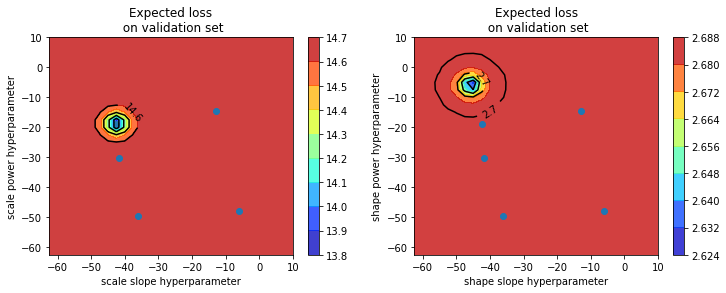

In [21]:
log_sample_points = np.random.uniform(low=l2_reg_min,high=l2_reg_max,
                                      size=[initial_GP_test_points,hyper_param_dim]).astype(np.float32)
sample_points = np.exp(log_sample_points)


f = FloatProgress(min=0, max=initial_GP_test_points-1)
display(f)
sample_values = []
for i in range(initial_GP_test_points):
    f.value = i
    sample_values += [train_model(l2_reg_strength_val = sample_points[i,:],num_steps=500,learning_rate=.1)]
log_sample_values = np.log(sample_values)

fit_GP(log_sample_points, log_sample_values, verbose = True)
plot_GP_model(log_sample_points,log_sample_values)

다음 validation-cross-entropy error 샘플을 위한 하이퍼 파라미터 선택을 가우시안 프로세스 모델을 사용해서 결정할거다.<br><br>

더 세부적으로, 우리는 우리 모델을 위해 기대 개선(expected improvement)을 최대화하는 $a_{EI}(x_{test})$에서 $x_{test}$ 포인트를 찾으려고 노력할거다. 그 포인트에서의 validation-cross-entropy-error 샘플도.<br><br>

gradient descent가 상대적으로 계산비용이 저렴하니, 변수 분리를 위한 $n=$ ```max_feelers```, 그리고 (logarithm) of ```GP_expected_improv```를 최소화하기 위해 gradient descent를 실행한다. 그리고 $x_{new}$ 최고의 결과를 선택할거임 <br><br>

In [22]:
with tf.variable_scope('GP-test-point-finder'):
    test_point_list=[]
    for i in range(max_feelers):
        test_point_list += [tf.Variable(tf.random_uniform([hyper_param_dim],l2_reg_min,l2_reg_max))]
    # our test point is randomly initialized
    GP_test_points = tf.stack(test_point_list)
    # For the kernel we stop gradients from back-propagating to the length scale and noise estimates.
    GP_fixed_kernel = lambda l2x,l2y:matern_kernel(l2x,l2y,
                                                     tf.stop_gradient(GP_log_length_scale),
                                                     tf.stop_gradient(GP_log_sample_noise),
                                                    tf.stop_gradient(GP_log_kernel_scale))
    GP_test_point_losses = -GP_expected_improv(GP_fixed_kernel, GP_sampled_x,GP_sampled_y,GP_test_points)
    GP_test_point_optimizer = tf.train.AdamOptimizer(.1)
    GP_test_point_train = GP_optimizer.minimize(tf.reduce_mean(GP_test_point_losses))

오케이, 우리의 모델을 위한 향상된 $a_{PI}(x_{test})$의 확률을 최대화하는 테스트 포인트를 반복적으로 찾아봅시다

FloatProgress(value=0.0, max=15.0)

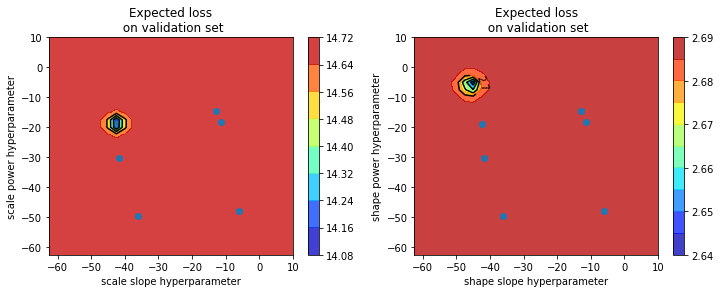

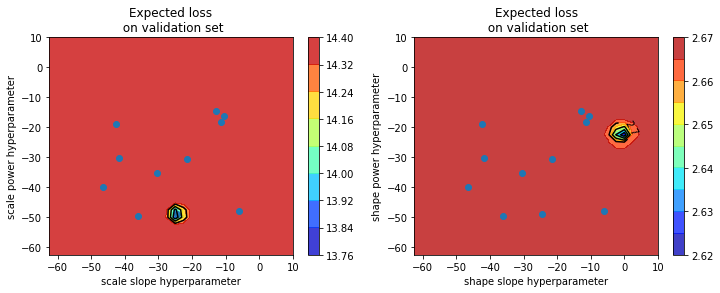

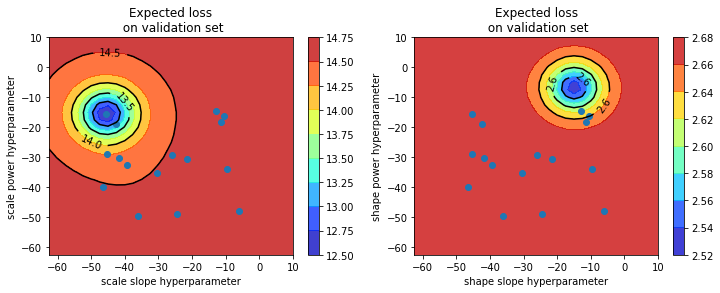

D:\ana_conda\envs\tf\lib\site-packages\matplotlib\contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


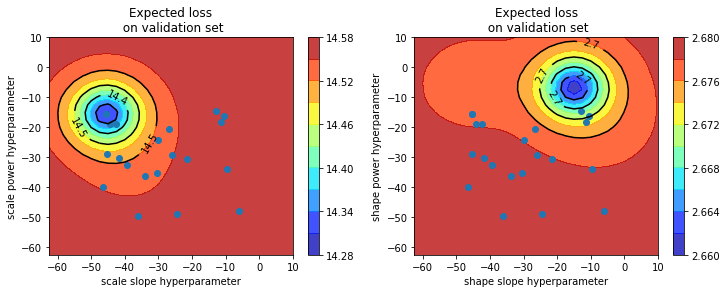

In [23]:
def find_test_point():
#     model_variables = tf.get_collection(tf.GraphKeys.VARIABLES, scope='GP-test-point-finder')
    model_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='GP-test-point-finder')
    tf.variables_initializer(model_variables).run()
    # optimize the probability of improvement:
    for j in range(100):
        cur_points, losses, _ = sess.run([GP_test_points,GP_test_point_losses,GP_test_point_train],
                           {GP_sampled_x:log_sample_points,
                           GP_sampled_y:log_sample_values})
        for i in range(max_feelers):
            if not np.isfinite(cur_points[i]).all():
                print('resetting feeler')
                tf.variables_initializer([test_point_list[i]]).run()
    min_index = np.argmin(losses)
    return cur_points[min_index,:]

new_tests = total_GP_test_points - initial_GP_test_points+1
f = FloatProgress(min=0, max=new_tests-1)
display(f)
for i in range(new_tests):
    f.value = i
    test_point = find_test_point()
    # print("%d'th test at: (%.3f,%.3f)"%(i,test_point[0],test_point[1]))
    if np.isfinite(test_point).all():
        # add the test point to our list of sampled points
        log_sample_points = np.append(log_sample_points,[test_point],axis = 0)
        sample_points = np.append(sample_points,[np.exp(log_sample_points[-1,:])],axis = 0)
        # estimate the validation-cross-entropy error at the new test point
        sample_values = np.append(sample_values,
                                  [train_model(l2_reg_strength_val = sample_points[-1,:],
                                               num_steps=500,learning_rate=.1)],
                                 axis = 0)
        log_sample_values = np.append(log_sample_values,[np.log(sample_values[-1])],axis=0)
    else:
        print('not finite')
    # Fit the Gaussian process model (after every 5 new test points)
    if i % 5 == 0:
        fit_GP(log_sample_points, log_sample_values)
    # display the results (every 20 new points)
    if i % 5 == 0:
        plot_GP_model(log_sample_points,log_sample_values)
    

가우시안 프로세스 모델 결과를 사용해 하이퍼 파라미터 최선의 값을 찾아봅시당:

In [24]:
with tf.variable_scope('GP-best-point-finder'):
    best_point_list=[]
    for i in range(max_feelers):
        best_point_list += [tf.Variable(tf.random_uniform([hyper_param_dim],l2_reg_min,l2_reg_max))]
    # our best point is randomly initialized
    GP_best_points = tf.stack(best_point_list)
    # For the kernel we stop gradients from back-propagating to the length scale and noise estimates.
    GP_fixed_kernel = lambda l2x,l2y:matern_kernel(l2x,l2y,
                                                     tf.stop_gradient(GP_log_length_scale),
                                                     tf.stop_gradient(GP_log_sample_noise),
                                                    tf.stop_gradient(GP_log_kernel_scale))
    GP_best_point_means = GP_mean(GP_fixed_kernel,GP_sampled_x,GP_sampled_y,GP_best_points)
    GP_best_point_optimizer = tf.train.AdamOptimizer(.05)
    GP_best_point_train = GP_optimizer.minimize(tf.reduce_mean(GP_best_point_means))
    
model_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='GP-best-point-finder')
tf.variables_initializer(model_variables).run()
# find the value of best_point which minimizes the Gaussian process:
for j in range(1000):
    cur_points,means,_ = sess.run([GP_best_points,GP_best_point_means,GP_best_point_train],
                    {GP_sampled_x:log_sample_points,
                    GP_sampled_y:log_sample_values})
#     if j % 100 == 0:
#         print(GP_best_point.eval())  
    for i in range(max_feelers):
        if not np.isfinite(cur_points[i]).all():
            print('resetting feeler')
            tf.variables_initializer([best_point_list[i]]).run()
min_index = np.argmin(means)
best_point = cur_points[min_index,:]

resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feeler
resetting feel

In [25]:
GP_min_point_est = np.exp(best_point)
GP_min_value_est = tf.exp(GP_mean_func).eval({GP_sampled_x:log_sample_points,
                           GP_sampled_y:log_sample_values,
                            GP_new_x:[best_point]})
GP_min_error_est = GP_min_value_est*tf.sqrt(tf.reduce_mean(GP_cov_func)).eval({GP_sampled_x:log_sample_points,
                           GP_sampled_y:log_sample_values,
                            GP_new_x:[best_point]})
print("Expected minimum validation-cross entropy: %.4f +- %.4f" %(GP_min_value_est,GP_min_error_est))
print("At point: (%.4f,%.4f,%.4f,%.4f)"%(best_point[0],best_point[1],best_point[2],best_point[3]))
print("Corresponding to hyperparameters:\n\
        prior confidence of constant scale: %.4f,\n\
        prior confidence of scale growing linearly: %.4f,\n\
        prior confidence of constant shape: %.4f,\n\
        prior confidence of shape decreasing inverse-linearly: %.4f"\
      %(np.sqrt(GP_min_point_est[0]),
        np.sqrt(GP_min_point_est[1]),
        np.sqrt(GP_min_point_est[2]),
        np.sqrt(GP_min_point_est[3])))

Expected minimum validation-cross entropy: 14.1765 +- 3.2047
At point: (-39.3259,-32.7787,-4.5992,-20.3489)
Corresponding to hyperparameters:
        prior confidence of constant scale: 0.0000,
        prior confidence of scale growing linearly: 0.0000,
        prior confidence of constant shape: 0.1003,
        prior confidence of shape decreasing inverse-linearly: 0.0000


최적화된 하이퍼 파라미터들과 함께 우리 모델을 트레이닝 해보죠:

In [26]:
train_model(l2_reg_strength_val=GP_min_point_est,verbose=True)

step: 0, loss: 20.601, a: 0.0500, b: 0.0461, min scale: 0.9512, scale rate of change: 0.9500, 
                      min shape: 1.0513 shape rate of change: 0.95
step: 100, loss: 12.409, a: 0.0930, b: 0.0634, min scale: 1.0188, scale rate of change: 0.7172, 
                      min shape: 2.0501 shape rate of change: 0.19
step: 200, loss: 12.662, a: 0.0501, b: -0.0402, min scale: 1.1166, scale rate of change: 0.6207, 
                      min shape: 2.0076 shape rate of change: 0.08
step: 300, loss: 9.172, a: -0.0019, b: -0.1456, min scale: 1.0824, scale rate of change: 0.3888, 
                      min shape: 2.0570 shape rate of change: 0.18
step: 400, loss: 12.574, a: -0.0651, b: -0.2094, min scale: 1.6458, scale rate of change: 0.5218, 
                      min shape: 3.4101 shape rate of change: 0.40
step: 500, loss: 14.281, a: 0.4570, b: 0.3069, min scale: 3.1530, scale rate of change: 0.4589, 
                      min shape: 3.4472 shape rate of change: 0.38
step: 600, los

12.243451

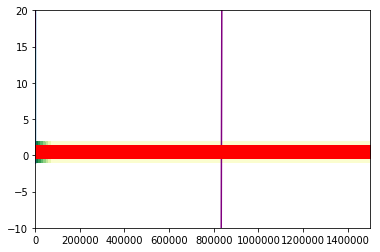

In [27]:
plot_model(ylim=[-10,20])

드디어, 테스트 셋의 error를 확인할 수 있습니다:

In [28]:
test_set_cross_entropy = cross_entropy.eval({x:test_data[:,0],y_:test_data[:,1]})
print("Test Set Cross Entropy Error: %.4f"%test_set_cross_entropy)

Test Set Cross Entropy Error: 12.2466
